<a href="https://colab.research.google.com/github/luqmanrofifm/Plant-Diseases-Image-Classifier/blob/main/Plant_Diseases_Image_Classifier_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Akses Gooogle Drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Ekstrak file datase


In [ ]:
!unzip "/content/gdrive/My Drive/Colab Notebooks/Dicoding/train.zip"

Output streaming akan dipotong hingga 5000 baris terakhir.
  inflating: train/Tomato___Target_Spot/3a53fede-6ec6-4e6c-a19f-ad1324604ca8___Com.G_TgS_FL 8086_180deg.JPG  
  inflating: train/Tomato___Target_Spot/3a53fede-6ec6-4e6c-a19f-ad1324604ca8___Com.G_TgS_FL 8086_flipTB.JPG  
  inflating: train/Tomato___Target_Spot/3a53fede-6ec6-4e6c-a19f-ad1324604ca8___Com.G_TgS_FL 8086_new30degFlipLR.JPG  
  inflating: train/Tomato___Target_Spot/3a72a7cf-4406-4bad-9bf2-582ce0daaf86___Com.G_TgS_FL 8336.JPG  
  inflating: train/Tomato___Target_Spot/3a72a7cf-4406-4bad-9bf2-582ce0daaf86___Com.G_TgS_FL 8336_180deg.JPG  
  inflating: train/Tomato___Target_Spot/3a72a7cf-4406-4bad-9bf2-582ce0daaf86___Com.G_TgS_FL 8336_flipTB.JPG  
  inflating: train/Tomato___Target_Spot/3a72a7cf-4406-4bad-9bf2-582ce0daaf86___Com.G_TgS_FL 8336_new30degFlipLR.JPG  
  inflating: train/Tomato___Target_Spot/3a72a7cf-4406-4bad-9bf2-582ce0daaf86___Com.G_TgS_FL 8336_newPixel25.JPG  
  inflating: train/Tomato___Target_Spot/3a8d5e93

Split dataset

In [ ]:
!pip install split_folders


In [ ]:
import splitfolders

splitfolders.ratio('train', output="dataset2", seed=1337, ratio=(.8, .2))

Copying files: 70295 files [00:12, 5447.85 files/s]


In [ ]:
train = '/content/dataset2/train'
val = '/content/dataset2/val'

Augmentasi dataset

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=30,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 2.5,
                    zoom_range = 0.3,
                    fill_mode = 'reflect')
 
val_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 1.7,
                    zoom_range = 0.3,
                    fill_mode = 'reflect')

'''
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    fill_mode = 'nearest')
 
val_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    vertical_flip=True,
                    shear_range = 1.7,
                    zoom_range = 0.2,
                    fill_mode = 'nearest')
'''


In [ ]:
train_generator = train_datagen.flow_from_directory(
        train, 
        target_size=(128, 128),
        batch_size=16,
        class_mode='categorical')
 
validation_generator = val_datagen.flow_from_directory(
        val,
        target_size=(128, 128), 
        batch_size=16,
        class_mode='categorical')

Found 56219 images belonging to 38 classes.
Found 14076 images belonging to 38 classes.


Menyiapkan model transfer learning

In [ ]:

import tensorflow as tf
from tensorflow.keras.optimizers import RMSprop

IMG_SHAPE = (128, 128, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                              include_top=False, 
                                              weights='imagenet')

9412608/9406464 [==============================] - 1s 0us/step


In [ ]:
base_model.trainable = False

Membuat model

In [ ]:
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(38, activation='softmax')
])


'''
model = tf.keras.Sequential([
  base_model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(38, activation='softmax')
])
'''

NameError: ignored

Menyiapkan callback

In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.85 and logs.get('val_accuracy') > 0.85):
      print("\nAkurasi dan Validasi Akurasi telah mencapai > 85%!")
      self.model.stop_training = True
callbacks = myCallback()

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'],)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Functi (None, 4, 4, 1280)        2257984   
_________________________________________________________________
dropout (Dropout)            (None, 4, 4, 1280)        0         
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
flatten (Flatten)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 38)                48678     
Total params: 2,306,662
Trainable params: 48,678
Non-trainable params: 2,257,984
_________________________________________________________________


Proses training

In [ ]:
history = model.fit(
          train_generator,
          steps_per_epoch=25,
          epochs=100,
          validation_data=validation_generator,
          validation_steps=15, 
          callbacks=[callbacks])

Epoch 1/100
25/25 [==============================] - 10s 390ms/step - loss: 2.4960 - accuracy: 0.3100 - val_loss: 2.1421 - val_accuracy: 0.4083
Epoch 3/100
25/25 [==============================] - 10s 393ms/step - loss: 2.0592 - accuracy: 0.4150 - val_loss: 1.7198 - val_accuracy: 0.5292
Epoch 4/100
25/25 [==============================] - 10s 395ms/step - loss: 1.6049 - accuracy: 0.5575 - val_loss: 1.5213 - val_accuracy: 0.6125
Epoch 5/100
25/25 [==============================] - 10s 392ms/step - loss: 1.4020 - accuracy: 0.5875 - val_loss: 1.3493 - val_accuracy: 0.6292
Epoch 6/100
25/25 [==============================] - 10s 390ms/step - loss: 1.2139 - accuracy: 0.6600 - val_loss: 1.2121 - val_accuracy: 0.6458
Epoch 7/100
25/25 [==============================] - 10s 389ms/step - loss: 1.1974 - accuracy: 0.6700 - val_loss: 1.1552 - val_accuracy: 0.6750
Epoch 8/100
25/25 [==============================] - 10s 390ms/step - loss: 1.2017 - accuracy: 0.6600 - val_loss: 1.1102 - val_accuracy:

Plot hasil training

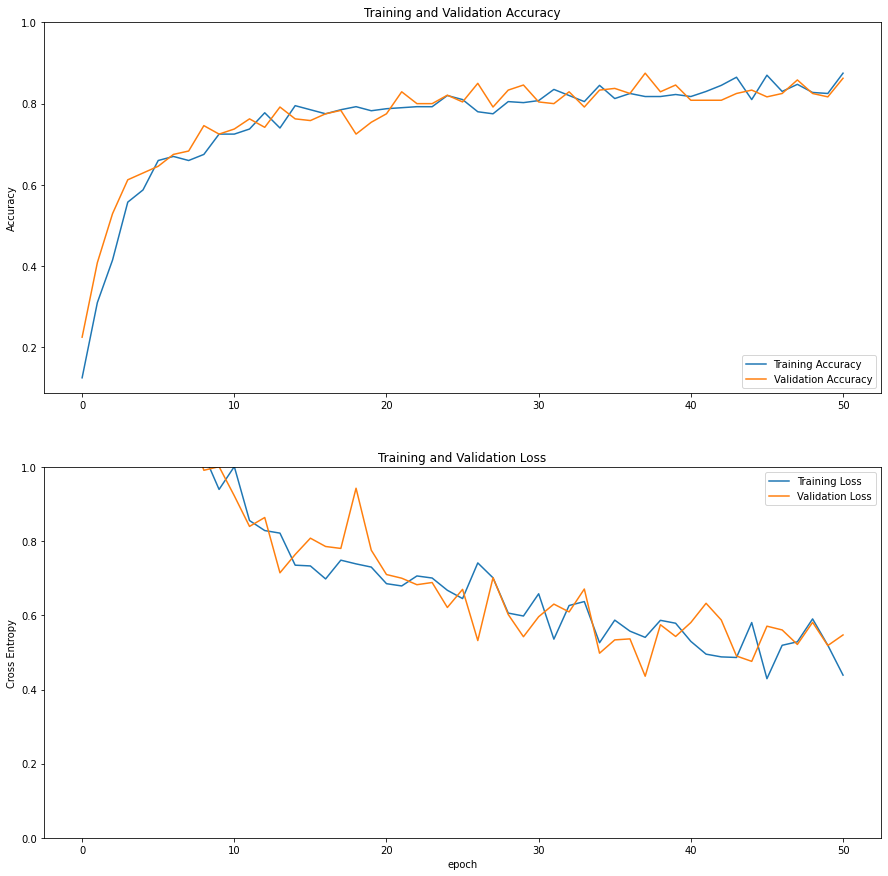

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Proses Fine Tuning

In [ ]:
base_model.trainable = True

In [ ]:
 print("Number of layers in the base model: ", len(base_model.layers))

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  155


In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.Adam(1e-5),
              metrics=['accuracy'])

Melanjutkan proses train

In [ ]:
history_fine = model.fit(
          train_generator,
          steps_per_epoch=25,
          epochs=100,
          validation_data=validation_generator,
          validation_steps=15, 
          callbacks=[callbacks])

Epoch 1/100
25/25 [==============================] - 15s 605ms/step - loss: 2.8316 - accuracy: 0.4175 - val_loss: 0.5323 - val_accuracy: 0.8417
Epoch 2/100
25/25 [==============================] - 14s 575ms/step - loss: 2.8791 - accuracy: 0.3675 - val_loss: 0.4965 - val_accuracy: 0.8292
Epoch 3/100
25/25 [==============================] - 14s 573ms/step - loss: 2.2817 - accuracy: 0.4375 - val_loss: 0.5408 - val_accuracy: 0.8333
Epoch 4/100
25/25 [==============================] - 14s 573ms/step - loss: 2.3440 - accuracy: 0.4400 - val_loss: 0.5237 - val_accuracy: 0.8333
Epoch 5/100
25/25 [==============================] - 14s 571ms/step - loss: 2.2262 - accuracy: 0.4425 - val_loss: 0.4913 - val_accuracy: 0.8542
Epoch 6/100
25/25 [==============================] - 14s 573ms/step - loss: 2.0387 - accuracy: 0.4775 - val_loss: 0.6143 - val_accuracy: 0.8000
Epoch 7/100
25/25 [==============================] - 14s 572ms/step - loss: 1.8402 - accuracy: 0.5425 - val_loss: 0.5847 - val_accuracy:

Plot hasil train lanjutan

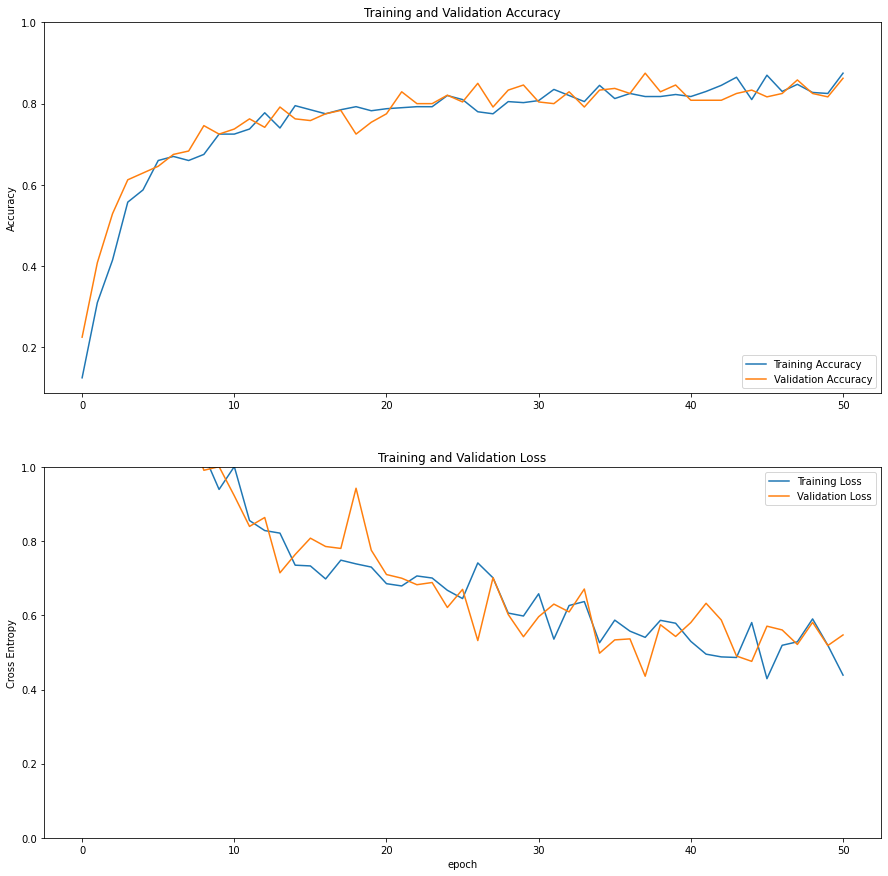

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()


Mengubah model dalam bentuk tflite

In [ ]:
saved_model_dir = 'save/fine_tuning'
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: save/fine_tuning/assets
